# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import random
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [4]:
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

### Data

In [5]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [6]:
train_merge = merge_basic(daily_train, test,'left')

In [7]:
train_merge.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,comp1_x,comp2_x,map_comp1categ,map_comp2categ,shop_name,comp1_y,comp2_y,map_comp1shop,map_comp2shop,ID,SaleDate
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Blu-Ray,11,19,"Ярославль ТЦ ""Альтаир""",Ярославль,Альтаир,31,45,150983.0,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,Винил,13,39,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,CD фирменного производства,13,37,"Москва ТРК ""Атриум""",Москва,Атриум,14,18,NaN,2013-01-15


In [8]:
wholedata_silver = convert_silver(train_merge)

In [9]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_name,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,InTest,item_cnt_day,item_price,shopitem
0,2013-01-01,0,0,32,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,6.0,221.0,0-32
1,2013-01-01,0,0,33,1+1 (BD),37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,0,3.0,347.0,0-33
2,2013-01-01,0,0,35,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,247.0,0-35
3,2013-01-01,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,221.0,0-43
4,2013-01-01,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,13,38,0,0,0,2.0,130.0,0-51


In [10]:
wholedata_silver.shape

(1609124, 16)

<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [11]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [12]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

#### hold-out Train

In [13]:
train_big_full = completion_semi_gold(wholedata_silver)

In [14]:
train_big_full.columns

Index(['InTest', 'shop_id', 'item_id', 'item_name', 'shopitem',
       'item_category_id', 'shop_name', 'item_category_name', 'map_comp1categ',
       'map_comp2categ', 'map_comp1shop', 'map_comp2shop', 'Date', 'Sale',
       'item_price', 'Order', 'MiguelId'],
      dtype='object')

In [15]:
date_val = datetime.datetime(2014, 10, 1)

In [16]:
train_full = train_big_full[train_big_full.Date < date_val ].copy()
val_window = train_big_full[train_big_full.Date == date_val ].copy()

In [17]:
train_full.head()

,InTest,shop_id,item_id,item_name,shopitem,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,Date,Sale,item_price,Order,MiguelId
0,0,0,30,007: КООРДИНАТЫ «СКАЙФОЛЛ»,0-30,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,0.0,0.0,1,0-30-2013-01-01
1,0,0,31,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),0-31,37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,2013-01-01,0.0,0.0,1,0-31-2013-01-01
2,0,0,32,1+1,0-32,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,6.0,221.0,1,0-32-2013-01-01
3,0,0,33,1+1 (BD),0-33,37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,2013-01-01,3.0,347.0,1,0-33-2013-01-01
4,0,0,35,10 ЛЕТ СПУСТЯ,0-35,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,1.0,247.0,1,0-35-2013-01-01


In [18]:
train_full.Date.max(), train_full.Date.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [19]:
train_full.shape

(8906604, 17)

In [20]:
train_full.groupby('InTest').agg(shopitems = ('shopitem','nunique'))

,shopitems
InTest,
0,312720
1,111404


### Exploration of the features

In [21]:
def balance_items_test(data, date_to_take , percentage_test = 0.30, smalls_percent = 0.5, gen_sample = 0.70):
    
    data = data[data.Date < date_to_take].copy()
    
    ## data from not in test
    
    items_in_test = list(data[data.InTest == 1].shopitem.unique())
    items_in_test = [str(x) for x in items_in_test]
    
    items_no_test = list(data[data.InTest == 0].shopitem.unique())
    items_no_test = [str(x) for x in items_no_test]
    ncapture = int(round(len(items_no_test)*percentage_test,0 ))
    random.shuffle(items_no_test)
    items_no_test = items_no_test[0:ncapture]
    
    selected_items = items_in_test + items_no_test
    data = data[data.shopitem.isin(selected_items)]
    
    ## data min item
    data['max'] = data.groupby(['shopitem']).Sale.transform('max')
    smalls = list(data[data['max'] < 2].shopitem.unique())
    to_drop = int( round(len(smalls)*smalls_percent,0 ))
    items = [str(x) for x in smalls]
    random.shuffle(items)
    keep_items = items[0:to_drop]
    data = data[~data.shopitem.astype('str').isin(keep_items)].drop(columns = ['max'])
    
    ## for general sample
    to_hide = int( round(len(data.shopitem.unique())*gen_sample,0 ))
    items = list(data.shopitem.unique())
    items = [str(x) for x in items]
    random.shuffle(items)
    
    keep_items = items[0:to_hide]
    data_result = data[data.shopitem.astype('str').isin(keep_items)]
    
    return data_result

In [22]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.90)

In [23]:
def exploiting_words(data):
    items_vector = list(data.item_name.unique())
    items_vector = pd.DataFrame({'item_name': items_vector})
    items_vector['lenstr'] = items_vector.item_name.str.len() ## this can be a feature
    items_vector['NWords'] = items_vector.item_name.str.split().str.len()
    items_vector['Word0'] = items_vector.item_name.str.split().str.get(0)
    items_vector['Word_1'] = items_vector.item_name.str.split().str.get(-1)
    
    def my_tokengen(data, columnx):
        unique_words = list()
        for string in  list(data[columnx].values):
            for word in string.split():
                unique_words.append(word)
        unique_words = set(unique_words)
        unique_words = list(unique_words)
        unique_words.sort()
        number = [idx[0] +1 for idx in enumerate(unique_words)]
        map_word = {x:y for x,y in zip(unique_words, number)}

        data[columnx] = data[columnx].map(map_word)
        return data
    
    items_vector = my_tokengen(items_vector, 'Word0')
    items_vector = my_tokengen(items_vector, 'Word_1')
    items_vector = items_vector.merge(items[['item_name','item_id']], on = 'item_name', how = 'left').drop(columns = 'item_name')
    
    return {'item_name_explo':items_vector}

In [24]:
def get_full_lags(whole, date_to_take):
    
    data = whole[ whole.Date < date_to_take].copy()
    data['itemShopMax'] = data.groupby(['shopitem']).Sale.transform('max')
    data['possnumb'] = np.where(data.Sale > 0 , 1,0)
    data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')
    
    features_dictionary = dict()
    #########################################
    ### only item Columns  ##################
    ########################################

    date_max = data.Date.max()
    date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
    
    #########################################
    ### starts  ##################
    ########################################
    
    data['itempMax'] = data.groupby(['item_id']).Sale.transform('max')
    data['maxOrder'] = data.groupby(['item_id','possnumb']).cumcount() + 1
    data['maxOrder'] = np.where(data.possnumb == 0 , 0, data['maxOrder'] )
    data['OrderGot'] = np.where(data.maxOrder == 1, data.Order,0)
    data['OrderGot'] = data.groupby(['item_id']).OrderGot.transform('sum')
    
    starts = data.groupby('item_id').agg(OrderGot = ('OrderGot','max')).reset_index()
    
    features_dictionary['Starts'] = starts
    
    
    ########################################
    #### explosionts ###############
    #########################################
    data['SpaceOrder'] = data['Order'] - data['OrderGot']
    df_feature = data[data.SpaceOrder >= 0].copy()
    df_feature['Sale'] = np.where(df_feature['Sale'] == 0, np.nan, df_feature['Sale'])
    df_feature_item = df_feature.groupby(['item_id','SpaceOrder']).agg(maxSaleItem = ('Sale','mean')).reset_index()
    
    features_dictionary['Item pattern'] = df_feature_item
    
    #########################
    #### level  Item ######
    #########################
    
    data_to_use = data.copy()
    data_to_use['SpaceOrder'] = data_to_use['Order'] - data_to_use['OrderGot']
    data_to_use['cero'] = np.where((data_to_use.SpaceOrder >= 0) & (data_to_use.Sale == 0), 1,0)
    
    data_to_use['Sale'] = np.where(data_to_use['Sale'] == 0, np.nan, data_to_use['Sale'])
    
    df_feature = data_to_use\
        .groupby(['item_id','Date'])\
        .agg(maxValueItemLev1 = ('Sale','mean'),
            countItemPossitives = ('possnumb','sum'),
            countItemZero = ('possnumb','sum'))\
        .reset_index()
    
    df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
    
    ## lags using max
    df_feature['L1maxLev1Item'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemLev1'].shift(0)
    df_feature['L2maxLev1Item'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemLev1'].shift(1)
    df_feature['L3maxLev1Item'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemLev1'].shift(2)
    df_feature['L4maxLev1Item'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemLev1'].shift(3)
    df_feature['L5maxLev1Item'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemLev1'].shift(4)

    df_feature['CategoryL1Item'] = np.where(df_feature['L1maxLev1Item'] < 2,'A',
            np.where(df_feature['L1maxLev1Item'] < 5,'B',
            np.where(df_feature['L1maxLev1Item'] < 10,'C','D')))
    df_feature_item = df_feature.drop(columns = ['maxValueItemLev1'])

    features_dictionary['Focus_item_features'] = df_feature_item
    
    #########################
    #### level  Item shop ######
    #########################
    
    data_to_use = data.copy()
    data_to_use['SpaceOrder'] = data_to_use['Order'] - data_to_use['OrderGot']
    data_to_use['cero'] = np.where((data_to_use.SpaceOrder >= 0) & (data_to_use.Sale == 0), 1,0)
    data_to_use['Sale'] = np.where(data_to_use['Sale'] == 0, np.nan, data_to_use['Sale'])
    
    df_feature = data_to_use\
        .groupby(['item_id','shop_id','Date'])\
        .agg(
            maxValueItemShopLev1 = ('Sale','mean'),
            countItemShopPossitives = ('possnumb','sum'),
            countItemShopZero = ('possnumb','sum')
            )\
        .reset_index()
    
    df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
    
    ## lags using max
    df_feature['L1maxLev1ItemShop'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemShopLev1'].shift(0)
    df_feature['L2maxLev1ItemShop'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemShopLev1'].shift(1)
    df_feature['L3maxLev1ItemShop'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemShopLev1'].shift(2)
    df_feature['L4maxLev1ItemShop'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemShopLev1'].shift(3)
    df_feature['L5maxLev1ItemShop'] = df_feature.sort_values('Date').groupby(['item_id'])['maxValueItemShopLev1'].shift(4)

    df_feature_item = df_feature.drop(columns = ['maxValueItemShopLev1'])

    features_dictionary['Focus_item_shop_features'] = df_feature_item
    #########################
    #### level  shop ######
    #########################
    
    data_to_use = data.copy()
    data_to_use['Sale'] = np.where(data_to_use['Sale'] == 0, np.nan, data_to_use['Sale'])
    
    df_feature = data_to_use\
        .groupby(['shop_id','Date'])\
        .agg(
            maxValueShopLev1 = ('Sale','mean'),
            )\
        .reset_index()
    
    df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
    
    ## lags using max
    df_feature['L1maxLev1Shop'] = df_feature.sort_values('Date').groupby(['shop_id'])['maxValueShopLev1'].shift(0)

    df_feature_shop = df_feature.drop(columns = ['maxValueShopLev1'])

    features_dictionary['Focus_shop_features'] = df_feature_shop
    
    ###########################
    #### Variational features ######
    #########################
    
    df_feature = data[data.Order >= data.Order.max() - 5]\
            [['shop_id','item_id','shopitem','Date','Order','Sale']].copy()
    df_feature['OrderGo'] = df_feature['Order'] - df_feature['Order'].min()
    df_feature = df_feature[df_feature.Sale > 2 ]  #optional
    df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
    df_feature['SaleL1M'] = df_feature.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    df_feature = df_feature.assign(L0M_L1M = df_feature.Sale - df_feature.SaleL1M)
    
    df_lag_var_item = df_feature.groupby(['item_id','Date']).agg(meanLaggedVars = ('L0M_L1M','mean')).reset_index()
    df_lag_mean_var_item = df_feature[df_feature.OrderGo >= 3].fillna(0)\
        .groupby(['item_id']).agg(meanLastLagsVars = ('L0M_L1M','mean')).reset_index()
    
    features_dictionary['item previous var'] = df_lag_var_item
    features_dictionary['item mean last vars'] = df_lag_mean_var_item
    
    #########################
    #### last month and order sold ######
    #########################

    df_feature = data[['shop_id','item_id','Order','Date','Sale']].copy()
    df_feature['Month'] = df_feature.Date.dt.month
    df_feature['SaleFlag'] = np.where(df_feature['Sale'] > 0,1,0)
    df_feature['Sale'] = np.where(df_feature['Sale'] == 0, np.nan, df_feature['Sale'])
    df_feature['LastOrder'] = df_feature.groupby(['shop_id','item_id','SaleFlag']).Order.transform('max')
    df_feature['LastOrder'] = np.where(df_feature['SaleFlag'] == 1 , df_feature['LastOrder'], 0)
    df_feature['LastOrder'] = df_feature.groupby(['shop_id','item_id']).LastOrder.transform('max')

    df_feature['LastMonth'] = np.where(df_feature['LastOrder'] == df_feature['Order'], df_feature['Month'],0)
    df_feature['LastMonth'] = df_feature.groupby(['shop_id','item_id']).LastMonth.transform('max')
    
    def get_lasts(data, variable, variable_y, get_order):
    
        df_last = data.groupby([variable,variable_y]).agg(count = ('Month','count')).reset_index().copy()
        df_last['orderCluster'] = df_last.groupby([variable])['count'].rank("first", ascending=False)

        vector = df_last.groupby(variable).agg(countClusters = (variable_y,'nunique')).reset_index().copy()

        for i in range(1,get_order+1):
            cluster_i = df_last[df_last.orderCluster == i][[variable,variable_y]].rename(columns = {variable_y:f'{variable}{variable_y}{i}'}).copy()
            vector = vector.merge(cluster_i, on = variable, how = 'left').copy()
            if i > 1:
                j = i - 1
                vector[f'{variable}{variable_y}{i}'] = np.where(vector[f'{variable}{variable_y}{i}'].isnull(),vector[f'{variable}{variable_y}{j}'],
                                                           vector[f'{variable}{variable_y}{i}'] )
            
        return vector.drop(columns = 'countClusters')
    
    lasthmonth_item = get_lasts(data = df_feature, variable = 'item_id', variable_y = 'LastMonth', get_order = 5)
    lasthOrder_item = get_lasts(data = df_feature, variable = 'item_id', variable_y = 'LastOrder', get_order = 5)
    
    features_dictionary['lasthmonth_item'] = lasthmonth_item
    features_dictionary['lasthOrder_item'] = lasthOrder_item
    
    ####################
    ### item price #####
    ####################
    
    df_feature = data[['shop_id','item_id','Date','Order','Sale','item_price']].copy()
    df_feature['Date'] = df_feature.Date + pd.DateOffset(months=1)
    df_feature['Sale'] = np.where(df_feature['Sale'] == 0, np.nan, df_feature['Sale'])
    df_feature['avgPrice'] = df_feature.groupby(['item_id','Order']).item_price.transform('mean')
    df_feature['L1Price'] = df_feature.sort_values('Date').groupby(['item_id','shop_id'])['item_price'].shift(1)
    
    df_feature = df_feature.groupby(['item_id','Date']).agg(meanL1Price = ('L1Price','mean')).reset_index()
    
    features_dictionary['meanL1Price_item'] = df_feature
    
    return features_dictionary

In [25]:
def feature_silver(data, date_to_take, Train = True):
    data = data.copy()
    
    if Train:
        data = data[ data.Date < date_to_take] 
    else:
        data = data[data.Date >= (date_to_take - relativedelta(months=1))]
    
    ## feature of diff using one lag
    data['SaleL1M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    data['SaleL2M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(2)
    
    data_lagdiff = data.assign(L0M_L1M = data.Sale - data.SaleL1M)  ### This is new target ???? but yeaaaaaHHH
    data_lagdiff = data_lagdiff.assign(L1M_L2M = data_lagdiff.SaleL1M - data_lagdiff.SaleL2M) 
    
    data_lagdiff = data_lagdiff.drop(columns = ['SaleL2M'])
    ## quasi item ids
    data_lagdiff['ItemIdPart1'] = data_lagdiff.item_id.astype('str').str.strip().str[-1]
    data_lagdiff['ItemIdPart2'] = data_lagdiff.item_id.astype('str').str.strip().str[-4]
    
    ## further quasi id
    data_lagdiff['CategIdItem3A'] =  data_lagdiff['item_id'].astype('int') % 5
    data_lagdiff['CategIdItem3B'] =  data_lagdiff['item_id'].astype('int') % 10
    
    ## month
    data_lagdiff = data_lagdiff.assign(month = data_lagdiff.Date.dt.month)
    
    max_date = data_lagdiff.Date.max() + relativedelta(months=1)
    max_date_month = max_date.month
    data_lagdiff['monthToPredict'] = np.where(data_lagdiff['month'] == max_date_month,1,0)
        
    ## year
    data_lagdiff['Year'] = data_lagdiff.Date.dt.year
    ## quarter
    data_lagdiff['Quarter'] = np.where(data_lagdiff.month.isin([1,2,3]),1,
                            np.where(data_lagdiff.month.isin([4,5,6]),2,
                            np.where(data_lagdiff.month.isin([7,8,9]),3,
                            np.where(data_lagdiff.month.isin([10,11,12]),4,0))))
    
    return data_lagdiff

In [26]:
def integration_new_features_map(data, dict_feature, filter_ceros = True):
    data_wow = data.copy()
        
    ## first merge
    data_wow = data_wow.merge(dict_feature['Starts'], on = ['item_id'], how = 'left')
    data_wow = data_wow.merge(dict_feature['Focus_item_features'], on = ['item_id','Date'], how = 'left')
    data_wow = data_wow.merge(dict_feature['Focus_item_shop_features'], on = ['item_id','shop_id','Date'], how = 'left')
    data_wow = data_wow.merge(dict_feature['item_name_explo'], on = ['item_id'], how = 'left')
    data_wow = data_wow.merge(dict_feature['Focus_shop_features'], on = ['shop_id','Date'], how = 'left')
    
    data_wow = data_wow.merge(dict_feature['item previous var'], on = ['item_id','Date'], how = 'left')
    #data_wow = data_wow.merge(features_dictionary['item mean last vars'], on = ['item_id'], how = 'left')

    data_wow = data_wow.merge(dict_feature['lasthmonth_item'], on = ['item_id'], how = 'left')
    data_wow = data_wow.merge(dict_feature['lasthOrder_item'], on = ['item_id'], how = 'left')
    data_wow = data_wow.merge(dict_feature['meanL1Price_item'], on = ['item_id','Date'], how = 'left')
    
    #data_wow = data_wow.merge(dict_feature['Cluster_items'], on = ['item_id'], how = 'left')

    ### further features
    
    data_wow['SpaceOrder'] = data_wow['Order'] - data_wow['OrderGot']
    data_wow['SpaceOrder'] = data_wow['SpaceOrder'].fillna(0)
    data_wow['SpaceOrder'] = np.where(data_wow['SpaceOrder'].isnull(), 0, data_wow['SpaceOrder'] )
    data_wow['SpaceOrderActivator'] = np.where(data_wow['SpaceOrder'] >= 3,'A' , 'B' ) ### this is q dummy
    
    if filter_ceros:
        data_wow = data_wow[data_wow.SpaceOrder >= 0]
    return data_wow

In [27]:
%%time
features_dictionary = get_full_lags(whole = train_full, date_to_take = date_val) ## for train but result easy in val
item_explo_names = exploiting_words(train_full)
#feature_cluster = get_clusters(data = train_full, n_clusters_features = 5, date_to_take = date_val )
full_features_dictionary = {**features_dictionary,
                            **item_explo_names
                            #**feature_cluster
                           }

Wall time: 2min 14s


In [28]:
%%time
data_train_selected = balance_items_test(train_full, date_to_take = date_val, percentage_test = 0.30, smalls_percent = 0.5, gen_sample = 0.25) ## for train
train_feature_tocomplete = feature_silver(data_train_selected, date_to_take = date_val, Train = True) ## for both

Wall time: 30.8 s


In [29]:
train_feature = integration_new_features_map(data = train_feature_tocomplete, dict_feature = full_features_dictionary)  ## for both not prob

In [30]:
def features_rows_train_silver(data, features, target ,validation = None, dates_back = 3, limit = 5,additional_val_cols = [], sample = 0.05):
    data = data.copy()
    if validation:
        data_result = data[ data.Date == validation][additional_val_cols +features + [target]]
        features_new = list(data_result.columns)
        features_new.remove(target)
        data_result = data_result[ features_new + [target]].fillna(0)
        
    else:
        ### splits
        ### conventional for regular time series
        dates_back = 3
        ### Date cqpture ####################
        date_max = date_val - relativedelta(months=1)
        months_to_get = [4,5,6,10,11]
        minyear = 2014
        min_date = date_max - relativedelta(months=dates_back)

        year_i = date_max.year

        dates_result = list()

        while year_i >= minyear:
            for monthi in months_to_get:
                dates_result.append(datetime.datetime(year_i, monthi, 1))
                dates_result = [x for x in dates_result if x <= date_max]
            year_i = year_i - 1

        dates_result = dates_result + [date_max - relativedelta(months=i) for i in range(0,dates_back +1)]
        dates_result = list(set(dates_result))
        dates_result.sort()
        dates_result = dates_result[::-1]

        list_dfs = list()
        for datex,i in zip(dates_result[0:limit], range(len(dates_result[0:limit]))):
            datex_plus1 = datex + relativedelta(months=1)
            features_dictionary = get_full_lags(whole = data, date_to_take = datex_plus1) ## for train but result easy in val
            item_explo_names = exploiting_words(train_full)
            full_features_dictionary = {**features_dictionary,
                                        **item_explo_names
                                       }
            
            data_train_selected = balance_items_test(data, date_to_take = datex_plus1, percentage_test = 0.30, smalls_percent = 0.5, gen_sample = sample) ## for train
            train_feature_tocomplete = feature_silver(data_train_selected, date_to_take = datex_plus1, Train = True) ## for both
            train_feature = integration_new_features_map(data = train_feature_tocomplete, dict_feature = full_features_dictionary)  ## for both not prob
            df = train_feature[train_feature.Date == datex]
            
            list_dfs.append(df)
            del df, train_feature, train_feature_tocomplete, data_train_selected, full_features_dictionary
            del features_dictionary
            #del feature_cluster
        data_result = pd.concat(list_dfs).fillna(0).reset_index(drop = True)

    return data_result

In [31]:
train_feature.columns 

Index(['InTest', 'shop_id', 'item_id', 'item_name', 'shopitem',
       'item_category_id', 'shop_name', 'item_category_name', 'map_comp1categ',
       'map_comp2categ', 'map_comp1shop', 'map_comp2shop', 'Date', 'Sale',
       'item_price', 'Order', 'MiguelId', 'SaleL1M', 'L0M_L1M', 'L1M_L2M',
       'ItemIdPart1', 'ItemIdPart2', 'CategIdItem3A', 'CategIdItem3B', 'month',
       'monthToPredict', 'Year', 'Quarter', 'OrderGot', 'countItemPossitives',
       'countItemZero', 'L1maxLev1Item', 'L2maxLev1Item', 'L3maxLev1Item',
       'L4maxLev1Item', 'L5maxLev1Item', 'CategoryL1Item',
       'countItemShopPossitives', 'countItemShopZero', 'L1maxLev1ItemShop',
       'L2maxLev1ItemShop', 'L3maxLev1ItemShop', 'L4maxLev1ItemShop',
       'L5maxLev1ItemShop', 'lenstr', 'NWords', 'Word0', 'Word_1',
       'L1maxLev1Shop', 'meanLaggedVars', 'item_idLastMonth1',
       'item_idLastMonth2', 'item_idLastMonth3', 'item_idLastMonth4',
       'item_idLastMonth5', 'item_idLastOrder1', 'item_idLastOrder2

In [32]:
to_drop_columns = ['Date']
ids_columns = ['item_category_id',
       'ItemIdPart1','ItemIdPart2', 'CategIdItem3A', 'CategIdItem3B'] #'item_id'
numericals = [ 'Quarter', 'OrderGot', 'countItemPossitives',
       'countItemZero', 'L1maxLev1Item', 'L2maxLev1Item', 'L3maxLev1Item',
       'L4maxLev1Item', 'L5maxLev1Item',
       'countItemShopPossitives', 'countItemShopZero', 'L1maxLev1ItemShop',
       'L2maxLev1ItemShop', 'L3maxLev1ItemShop', 'L4maxLev1ItemShop',
       'L5maxLev1ItemShop', 'lenstr', 'NWords', 'Word0', 'Word_1',
       'L1maxLev1Shop', 'meanLaggedVars', 'item_idLastMonth1',
       'item_idLastMonth2', 'item_idLastMonth3', 'item_idLastMonth4',
       'item_idLastMonth5', 'item_idLastOrder1', 'item_idLastOrder2',
       'item_idLastOrder3', 'item_idLastOrder4', 'item_idLastOrder5',
       'meanL1Price', 'SpaceOrder'] + ids_columns

categoricals = ['SpaceOrderActivator', 'CategoryL1Item']
my_features = to_drop_columns + numericals + categoricals
my_target = 'Sale'
len(my_features) - 3

39

In [33]:
train_full.Sale.max()

20.0

In [34]:
%%time
train_selection = features_rows_train_silver(data = train_full, features = my_features, target = my_target,limit = 1, sample = 0.65)

Wall time: 3min 10s


In [35]:
train_selection.Sale.max(), train_selection.SaleL1M.max()

(20.0, 20.0)

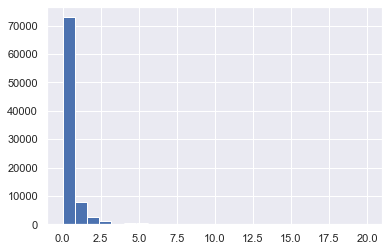

In [36]:
train_selection.Sale.hist(bins = 25)

In [37]:
def augmentation_reduction(data):
    data_wow = data.copy()
    zeros = np.array(data_wow[data_wow.Sale == 0].index)
    nx = int(round(zeros.shape[0]*0.7, 0))
    indexes = np.random.choice(zeros.shape[0], nx, replace=False)
    zeros_selected = zeros[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(zeros_selected)]
    
    ones = np.array(data_wow[data_wow.Sale == 1].index)
    nx = int(round(ones.shape[0]*0.1, 0))
    indexes = np.random.choice(ones.shape[0], nx, replace=False)
    ones_selected = ones[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(ones_selected)]
    
    twoes = np.array(data_wow[data_wow.Sale == 2].index)
    nx = int(round(twoes.shape[0]*0.1, 0))
    indexes = np.random.choice(twoes.shape[0], nx, replace=False)
    twoes_selected = twoes[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twoes_selected)]
    
    twenties = np.array(data_wow[data_wow.Sale == 20].index)
    nx = int(round(twenties.shape[0]*0.8, 0))
    indexes = np.random.choice(twenties.shape[0], nx, replace=False)
    twenties_selected = twenties[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twenties_selected)]
    
    #data_augmented_tens = data_wow[data_wow.Sale > 10].copy()
    data_augmented = pd.concat([data_wow, 
                               ],axis= 0).reset_index()
    
    return data_augmented

In [38]:
train_augmented = augmentation_reduction(train_selection)

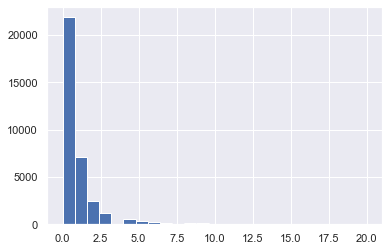

In [39]:
train_augmented.Sale.hist(bins = 25)

### continue ...

In [40]:
def scaler(dataset, features, target, scaler=None, drop_columns = []):
    if scaler:
        features = [x for x in features if x not in drop_columns]
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
        return dataset_scaled
    
    else:
        features = [x for x in features if x not in drop_columns]
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns, index = df.index)
        return dataset_scaled, scaler

In [41]:
my_columns_to_drops = ['SpaceOrderActivator_B', 'CategoryL1Item_B', 'Quarter',
       'CategoryL1Item_C', 'CategoryL1Item_D', 'SpaceOrderActivator_A',
       'countItemShopPossitives', 'item_idLastMonth5',
       'item_idLastMonth4']

In [42]:
train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
#train_scaled = train_augmented[ numericals + [my_target] ]
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_augmented[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [43]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [44]:
train_scaled.shape, train_selection.shape

((34547, 42), (86804, 63))

In [45]:
train_selection.Sale.max()

20.0

### ML modeling using ADAboost

In [46]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [47]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 30, min_samples_split = 10, min_samples_leaf = 10 , max_features = 20)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=40, learning_rate=0.005, loss='linear')
my_ABM.fit(X_train, Y_train)

Wall time: 1min 23s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=30,
                                                       max_features=20,
                                                       min_samples_leaf=10,
                                                       min_samples_split=10),
                  learning_rate=0.005, n_estimators=40)

<b> hold out validation

In [48]:
full_valandtrain_selected = val_window

In [49]:
full_valandtrain_selected.shape

(424124, 17)

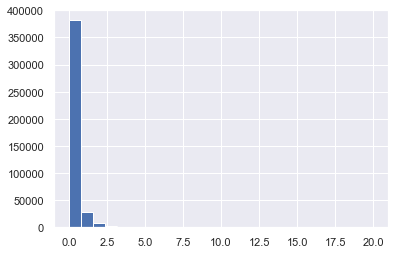

In [50]:
full_valandtrain_selected.Sale.hist(bins = 25)

In [51]:
valandtrain_feature = feature_silver(full_valandtrain_selected, date_to_take = date_val, Train = False)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature = full_features_dictionary, filter_ceros = True) 

In [52]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val, additional_val_cols = ['shop_id', 'item_id']) 

In [53]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
#val_scaled = val_selection[numericals + [my_target]]
if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [54]:
X_val = val_scaled_full[final_features]

In [55]:
Y_pred = my_ABM.predict(X_val)

In [56]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
#predicted_val['Sale'] = Y_pred

In [57]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)

In [58]:
my_lm_plot.shape , my_lm_plot.PredSale.min(), my_lm_plot.PredSale.max()

((424124, 5), 0.0, 19.71428571428571)

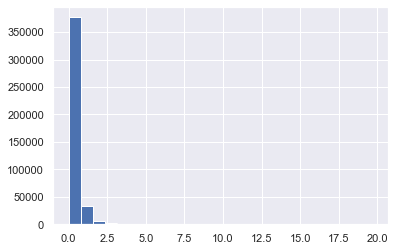

In [59]:
my_lm_plot.PredSale.hist(bins = 25)

In [60]:
mean_squared_error(my_lm_plot.Sale, my_lm_plot.PredSale) ** (1/2) ## 1.0109580870097943 using balancing just dropping 0s and 20s

1.0109580870097943

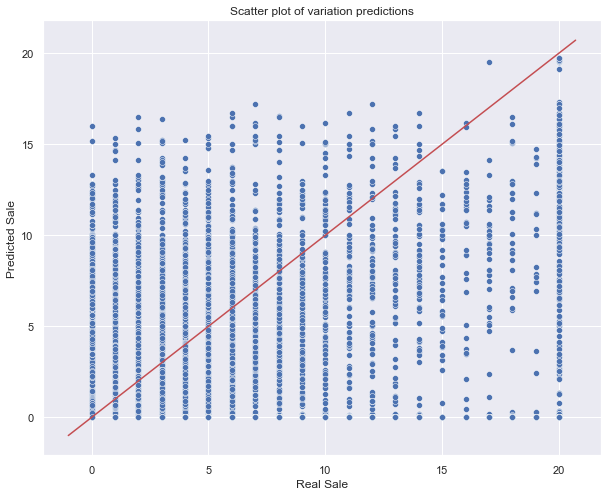

In [61]:
plot_prediction(my_lm_plot)

[Text(0.5, 1.0, 'feature importance')]

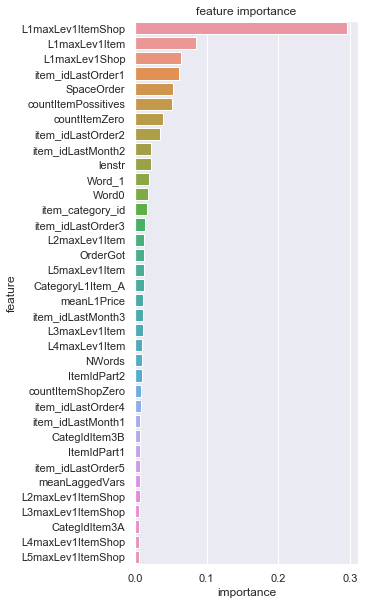

In [62]:
dfplot = pd.DataFrame({'feature':final_features,'importance': list(my_ABM.feature_importances_)}).sort_values('importance',ascending = False)

fig = plt.figure(figsize=(4,10))
ax = sns.barplot(x="importance", y="feature", data=dfplot)
ax.set(title='feature importance')

In [63]:
dfplot.sort_values('importance',ascending = True).head(10).feature.values

array(['L5maxLev1ItemShop', 'L4maxLev1ItemShop', 'CategIdItem3A',
       'L3maxLev1ItemShop', 'L2maxLev1ItemShop', 'meanLaggedVars',
       'item_idLastOrder5', 'ItemIdPart1', 'CategIdItem3B',
       'item_idLastMonth1'], dtype=object)

### Production of folds for cross validation

In [58]:
def get_splited_data(dates_vector):
    train_data = dict()
    validation_data = dict()
    
    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        train_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/train_selection.csv')
        val_selection = pd.read_csv(f'generated_datasets/data_{datex_str}/val_selection.csv')
        
        train_data[datex_str] = train_selection
        validation_data[datex_str] = val_selection
        print(datex_str)
    return { 'Train Data' : train_data, 
            'Validation Data': validation_data}

In [62]:
def My_ML_prediction_on_test( data_dict , dates_vector, model, frac = 0.80):

    data_result = list()

    for datex in dates_vector:
        datex_str = datex.strftime('%Y-%m-%d')
        #### reading files
        train_selection = data_dict['Train Data'][datex_str]
        val_selection = data_dict['Validation Data'][datex_str]
        train_selection = train_selection.sample(frac = frac)
        train_augmented = augmentation_reduction(train_selection)
        
        train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
        #train_scaled = train_augmented[ numericals + [my_target] ]
        if len(categoricals) != 0:
            train_dummies = pd.get_dummies(train_augmented[categoricals])
            train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)
        
        ### ML train
        X_train = train_scaled[final_features]
        Y_train = train_scaled[my_target]
        model.fit(X_train, Y_train)
        
        ### Test data prepa
        val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )
        
        if len(categoricals) != 0:
            val_dummies = pd.get_dummies(val_selection[categoricals])
            val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
        else:
            val_scaled_full = val_scaled
        
        X_val = val_scaled_full[final_features]
        
        ## Prediction
        Y_pred = model.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.Sale.values)
        data_result.append(my_lm_plot)
        #print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [60]:
dictionary_data = get_splited_data(dates_vector = test_dates)

2014-11-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01


In [63]:
%%time
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 30, min_samples_split = 10, min_samples_leaf = 10 , max_features = 25)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=40, learning_rate=0.005, loss='linear')
my_test_results = My_ML_prediction_on_test( data_dict = dictionary_data, dates_vector = test_dates, model = my_ABM, frac = 0.50)

Wall time: 12min 46s


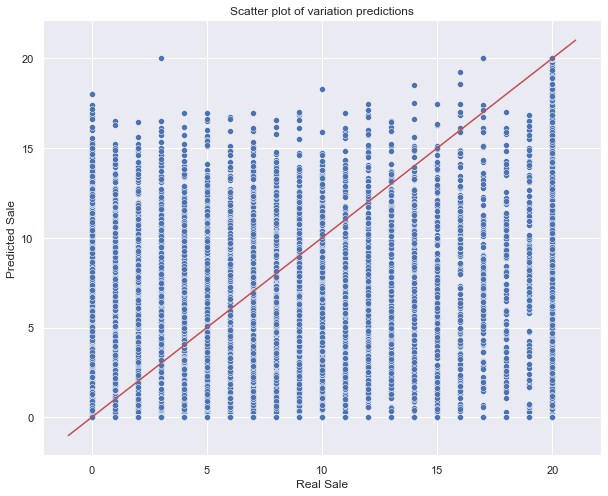

In [64]:
plot_prediction(my_test_results)

In [65]:
rmse_results = plot_metrics(my_test_results)

In [66]:
rmse_results.RMSE.mean() ## 0.7468165004618947 best one

0.7504301914483464

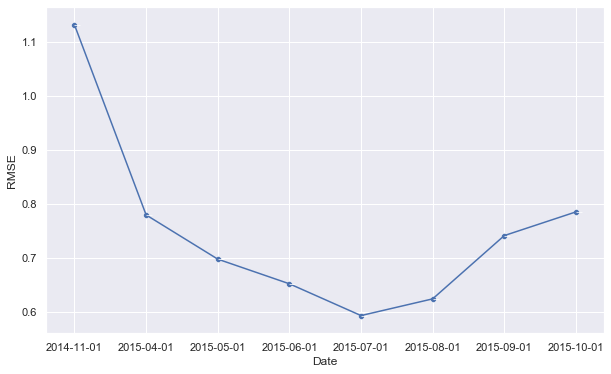

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

<b> checking errors

In [55]:
my_test_results_melt = my_test_results.assign(Class = np.where( my_test_results.Sale > 10, 'A',
                                                      np.where( my_test_results.Sale > 7, 'B',
                                                      np.where( my_test_results.Sale > 5, 'C',
                                                      np.where( my_test_results.Sale > 3, 'D','E')))))\
                            .assign(ABSerror = abs(my_test_results.Sale - my_test_results.PredSale))

In [56]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 75) )

ABSerror                                        
Class               A         B         C         D         E
Date                                                         
2014-11-01  20.000000  8.000000  6.000000  4.000000  0.315789
2015-04-01  17.941176  8.480263  5.900000  3.727273  0.200000
2015-05-01  20.000000  8.000000  5.095455  3.578125  0.153846
2015-06-01  14.000000  7.000000  5.029412  3.454545  0.100000
2015-07-01  11.595833  6.528846  4.900000  3.250000  0.090909
2015-08-01  13.000000  7.060662  5.062500  3.411765  0.090909
2015-09-01  17.737500  8.000000  5.243056  3.181818  0.105263
2015-10-01  18.625000  8.732057  6.000000  4.000000  0.111111

In [57]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 100) )

ABSerror                                       
Class             A     B          C          D          E
Date                                                      
2014-11-01     20.0  10.0  10.727273  12.727273  17.000000
2015-04-01     20.0  10.0  11.333333  13.333333  16.388889
2015-05-01     20.0  10.8   7.000000   8.312500  18.700000
2015-06-01     20.0  10.0   7.000000   9.400000  18.600000
2015-07-01     20.0  10.0   9.300000   8.454545  11.545455
2015-08-01     20.0  10.0   7.000000   6.307692  18.100000
2015-09-01     20.0  10.0   7.000000   8.384615  13.250000
2015-10-01     20.0  10.0   9.461538   8.928571  19.133333

some improvement :/
improve algo speed

### Basic K flod with Parameter tunning

In [69]:
my_adab_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,50, 50, 30, 30, 45, 60, 40, 50, 35],
    'min_samples_split':[10, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 10, 5, 15, 3, 15, 12],
    'max_features':[28, 30, 30, 25, 30, 21, 28, 23, 20, 30],
              
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.08, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [72]:
def my_kfold_crossval_and_Hptunning(data_dict, models_toTrain,frac = 1.0):

    results = {'machine label': list(),
        'machine result': list()}

    for machine,i in zip(models_toTrain, range(1,len(models_toTrain) + 1)):
        label = f'machine-{i}'
        results['machine label'].append(label)
        df_result = My_ML_prediction_on_test( data_dict = data_dict, dates_vector = test_dates, model = machine, frac = frac)
        results['machine result'].append(df_result)
        print(label + ' is done')
        
    return results

In [73]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_adab_models, frac = 0.005)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [74]:
def consolidated_plot_metrics(data):
    list_dfplot = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        df_plot = plot_metrics(result_detail)
        df_plot['machine'] = label
        list_dfplot.append(df_plot)
    
    return pd.concat(list_dfplot)

In [75]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

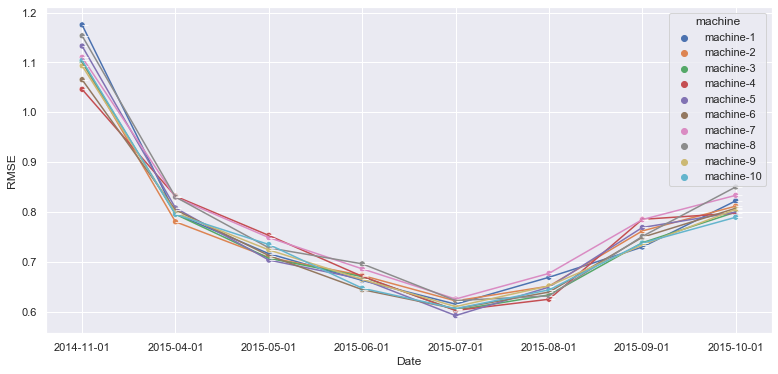

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [77]:
def consolidated_metrics_MSE(data):
    labels = list()
    RMSEs = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        pred = result_detail['Sale']
        real = result_detail['PredSale']
        rmse = mean_squared_error(real,pred)**(1/2)
        labels.append(label)
        RMSEs.append(rmse)
    
    return pd.DataFrame({'machine':labels,'RMSE': RMSEs}).sort_values('RMSE')

In [78]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
5,machine-6,0.766451
2,machine-3,0.770677
9,machine-10,0.771746
8,machine-9,0.773676
3,machine-4,0.775808
1,machine-2,0.777121
4,machine-5,0.781222
0,machine-1,0.791177
7,machine-8,0.799428
6,machine-7,0.799737


The winer is machine 6

### Winner Prediction

In [80]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_adab_models[5]], frac = 0.75)

machine-1 is done


In [81]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

In [82]:
np.mean(metrics_toplot.RMSE)  ## 0.7524171871872724 best

0.7524171871872724

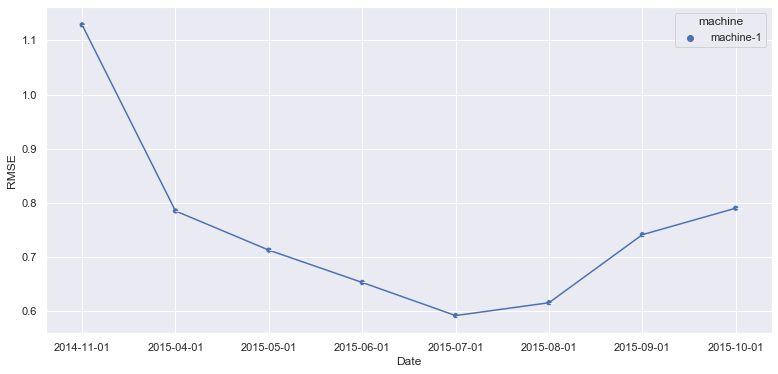

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

### Saving prediction for stacking

In [84]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_adaboost.csv',header = True, index = False)